In [1]:
PACKAGE_PATH = "F:\PSun-dev\Python\mlpp_project"

import os
import sys
sys.path.append(PACKAGE_PATH)

import collections
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import pyro
import torch

from ldavi.cavi import LDACAVI
from util import load_process

In [2]:
# need download stopwords first
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Peimo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
order, data, vocab = load_process()
data = data.values
data[:2]

array([list(['spring water', 'calcium vitamin', 'bean yogurt', 'organic bananas', 'almondmilk pudding', 'provalone cheese', 'crushed organic', 'almond milk', 'smoked bacon', 'hashed browns', 'oil olive', 'organic raspberries', 'cultured butter', 'guacamole', 'black beans', 'sorbet pops', 'dish soap', 'slices cheese', 'grassmilk milk', 'kombucha gingerade', 'hothouse cucumbers', 'salt added', 'apple sauce', 'genoa salami', 'queso fresco', 'sausage patty', 'sliced pepperoni', 'organic garlic', 'allpurpose flour', 'laundry detergent', 'parsley bunch', '2 buttermilk', 'yellow onion', 'chicken broth', 'string cheese', 'garbanzo beans', 'organic ketchup', 'organic zucchini', 'green chiles', 'salt added', 'organic lemonade', 'maize tortillas', 'corn starch', 'hand soap', 'plastic spoons', 'aluminum foil', 'plastic wrap', 'coconut milk']),
       list(['salad dressing', 'seedless grapes', 'organic bananas', 'chopped salad', 'wheat bread', 'greek yogurt', 'salad tomatoes', 'brown rice', 'butter

In [4]:
vocab

array(['cottage cheese', 'celery hearts', 'cucumber kirby', ...,
       'queen olives', 'prunes', 'albacore water'], dtype=object)

## CAVI on the sample data 

In [5]:
num_topics = 5
corpora = list(vocab)
alpha = torch.rand(size=(num_topics, )) * 10
beta = torch.rand(size=(len(alpha), len(vocab)))
beta = beta / beta.sum(-1).view(-1, 1)

cavi_obj = LDACAVI(alpha, beta, corpora, num_topics)

In [6]:
# Note that the ELBO here is the metric of the differences
# between the distribution of latent variables( theta, z | gamma, phi; theta, z | w). Therefore, the 
# ELBO is not necessarily smaller than Log_prob.

# Each step will take 16.5s on average (have 50 validate orders)

cavi_obj.reset_graph()
sample_data = data[:300]
alpha, beta = cavi_obj.estimate_params(sample_data, validate_data = data[300: 350],
                                       tol=2e-3) # valiate will decrease the training speed

Step 1 | beta diff norm=0.1254 | alpha diff norm=6.1323 | ELBO=44892.553 | Log_prob=-51871.383 | Validate_prob=-7876.616
Step 2 | beta diff norm=0.0052 | alpha diff norm=6.0337 | ELBO=35759.319 | Log_prob=-43060.816 | Validate_prob=-7931.069
Step 3 | beta diff norm=0.0042 | alpha diff norm=5.6735 | ELBO=35694.752 | Log_prob=-42876.32 | Validate_prob=-7906.425
Step 4 | beta diff norm=0.0042 | alpha diff norm=5.1922 | ELBO=35667.623 | Log_prob=-42993.457 | Validate_prob=-7861.566
Step 5 | beta diff norm=0.0042 | alpha diff norm=4.6054 | ELBO=35637.695 | Log_prob=-42969.039 | Validate_prob=-7857.973
Step 6 | beta diff norm=0.0043 | alpha diff norm=3.9213 | ELBO=35631.843 | Log_prob=-42982.34 | Validate_prob=-7897.613
Step 7 | beta diff norm=0.0045 | alpha diff norm=3.1518 | ELBO=35607.948 | Log_prob=-43250.09 | Validate_prob=-7911.087
Step 8 | beta diff norm=0.0046 | alpha diff norm=2.312 | ELBO=35589.829 | Log_prob=-43133.199 | Validate_prob=-7903.279
Step 9 | beta diff norm=0.0048 | alp

(1.0, 118.0)

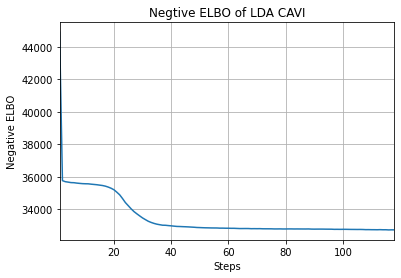

In [10]:
plt.plot(np.linspace(1, len(cavi_obj.trace_elbo), len(cavi_obj.trace_elbo)), cavi_obj.trace_elbo)
plt.title("Negtive ELBO of LDA CAVI")
plt.xlabel("Steps")
plt.ylabel("Negative ELBO")
plt.grid()
plt.xlim((1, len(cavi_obj.trace_elbo)))

(1.0, 118.0)

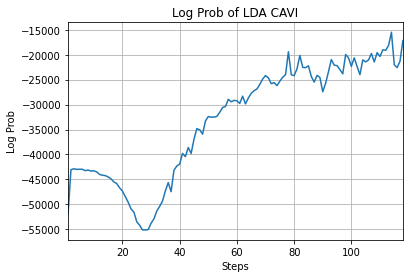

In [11]:
plt.plot(np.linspace(1, len(cavi_obj.trace_log_prob), len(cavi_obj.trace_log_prob)), cavi_obj.trace_log_prob)
plt.title("Log Prob of LDA CAVI")
plt.xlabel("Steps")
plt.ylabel("Log Prob")
plt.grid()
plt.xlim((1, len(cavi_obj.trace_log_prob)))

(1.0, 118.0)

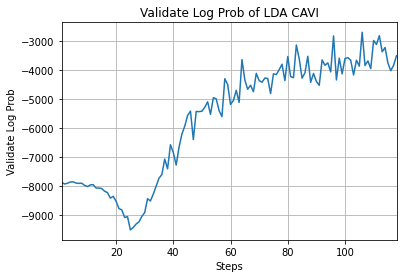

In [12]:
plt.plot(np.linspace(1, len(cavi_obj.trace_validate_prob), 
                     len(cavi_obj.trace_validate_prob)), cavi_obj.trace_validate_prob)
plt.title("Validate Log Prob of LDA CAVI")
plt.xlabel("Steps")
plt.ylabel("Validate Log Prob")
plt.grid()
plt.xlim((1, len(cavi_obj.trace_validate_prob)))

# Observation and Conclusion

1. Larger dataset needs more steps to converge. 

2. For CAVI based algorithm, the first update step will greatly increase the ELBO.  

2. The estimation of $\alpha$ depends on the convergence of $\beta$. The estimation of $\alpha$ depends on $\gamma$ in the CAVI of order level, while the esimation of $\gamma$ depends on the updates of $\phi$. Since the estimation of $\beta$ only depends on $\phi$, the estimation of $\alpha$ include the estimation error of phi and beta. The update order can be shown as follows:
 
     **Document(Order) CAVI level**:
     
     $\phi \xrightarrow{} \gamma$ 
     
     **EM Algorithm**:
     
     $\phi \xrightarrow{} \beta$ $\quad$ $\gamma \xrightarrow{} \alpha$

In the above example, the $gamma$ start converging after the 31st steps, and the log probability start to increase after that step.